# Kaggle: Housing Prices 

In this notebook we explore the [housing prices kaggle challenge](https://www.kaggle.com/c/house-prices-advanced-regression-techniques) with Google Colab.  


This is the second notebook in the housing prices kaggle challenge.  Here we explore Deep Learning techniques for performing the regression.



To begin, we will clone the repo to have access to the kaggle dataset.

In [1]:
!git clone https://github.com/demarley/figment

Cloning into 'figment'...
remote: Enumerating objects: 58, done.
remote: Counting objects: 100% (58/58), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 58 (delta 22), reused 42 (delta 13), pack-reused 0
Unpacking objects: 100% (58/58), done.


## Deep Learning Techniques

Now that we've covered some basic analysis techniques and boosted decision trees, let's explore some deep learning techniques for doing the regression.

To do this, we'll use `pytorch` as a way for me to learn about a different ML library.

To get `pytorch` setup on Google Colab, we'll follow the instructions [here](https://towardsdatascience.com/how-to-get-cuda-9-2-backend-for-pytorch-0-4-1-on-google-colab-57eb12aae27f).

In [2]:
!git clone https://gist.github.com/f7b7c7758a46da49f84bc68b47997d69.git

Cloning into 'f7b7c7758a46da49f84bc68b47997d69'...
remote: Enumerating objects: 16, done.
remote: Total 16 (delta 0), reused 0 (delta 0), pack-reused 16
Unpacking objects: 100% (16/16), done.


In [3]:
!mv f7b7c7758a46da49f84bc68b47997d69/pytorch041_cuda92_colab.sh pytorch041_cuda92_colab.sh
!rm -rf f7b7c7758a46da49f84bc68b47997d69/
!ls

figment  pytorch041_cuda92_colab.sh  sample_data


In [4]:
# Now setup pytorch 0.4.1 and cuda 9.2
!bash pytorch041_cuda92_colab.sh

--2018-11-05 15:14:16--  https://developer.nvidia.com/compute/cuda/9.2/Prod2/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.148-1_amd64
Resolving developer.nvidia.com (developer.nvidia.com)... 192.229.182.215
Connecting to developer.nvidia.com (developer.nvidia.com)|192.229.182.215|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://developer.download.nvidia.com/compute/cuda/9.2/secure/Prod2/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.148-1_amd64.deb?DvKsIQL0eSgbqKKR62dgzAwPJX8q-8uxdtwoGXroTH54HSBxqhFM15_hpwk0W-1unGBTgWSiWWv5q2ZHcFOSlJvn6abO3XRqfsgh2NbDREBWYOukUR4fNt-uDmfqYrtLveRaBZ52SUDL87EVXzmXq15nWIc5hnW8MhOQ1jEDOHs58CliuntzqqKq3QW-M4redkRr_pu1gGvty72V1203Dg [following]
--2018-11-05 15:14:17--  https://developer.download.nvidia.com/compute/cuda/9.2/secure/Prod2/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.148-1_amd64.deb?DvKsIQL0eSgbqKKR62dgzAwPJX8q-8uxdtwoGXroTH54HSBxqhFM15_hpwk0W-1unGBTgWSiWWv5q2ZHcFOSlJvn6abO3XRqfsgh2NbDREBWY

In [0]:
# plotting
import matplotlib.style
import matplotlib as mpl
mpl.style.use("default")
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import numpy as np
import pandas as pd

np.random.seed(2019)

In [0]:
# pytorch and scikit-learn
import torch
import torch.nn.functional as F
from torch.autograd import Variable

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import explained_variance_score  # quantifying accuracy of regression

### Data Cleaning 

From the previous notebooks, we know there are changes we can make to the dataset.  For now we won't do those here.  We will just leave the features that are textual alone for the time being. Let's look at the correlation matrix and choose some of the features more correlated with `SalePrice` (of the features that have numerical data).

In [0]:
# Read in the csv file as a pandas dataframe object
df = pd.read_csv("figment/data/housing_prices/train.csv");

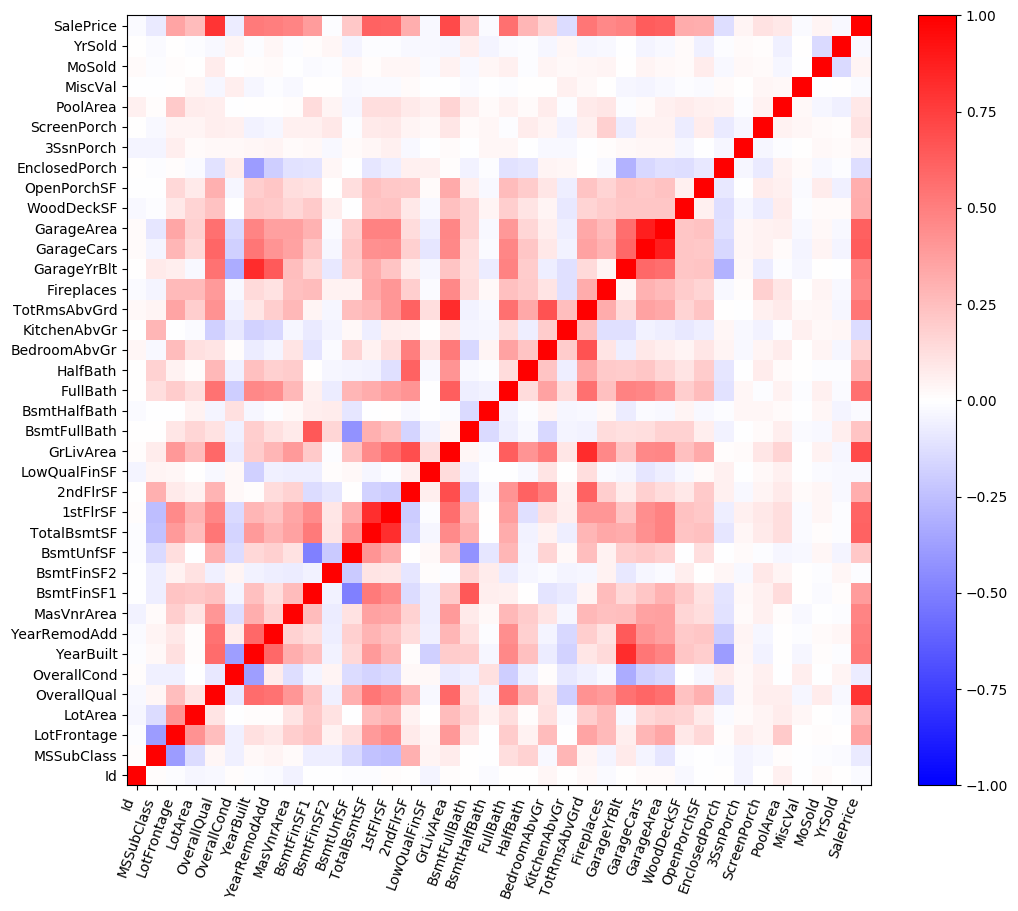

In [9]:
corrmat = df.corr()  # correlation matrix

fig,ax  = plt.subplots(figsize=(12,10))

opts    = {'cmap':plt.get_cmap("bwr"),'vmin':-1,'vmax':1}
heatmap = plt.pcolor(corrmat, **opts)
cbar    = plt.colorbar(heatmap, ax=ax)

labels = corrmat.columns.values

# shift location of ticks to center of the bins
ax.set_xticks(np.arange(len(labels))+0.5, minor=False);
ax.set_yticks(np.arange(len(labels))+0.5, minor=False);
ax.set_xticklabels(labels, fontsize=10, minor=False, ha='right', rotation=70);
ax.set_yticklabels(labels, fontsize=10, minor=False);

From this correlation matrix, let's choose some of the features most strongly correlated with `SalePrice`.  Then, split the data into a `training` and `validation` sets.

This attempt will use a somewhat random pick of features.  We'll just look at features that have correlations greater than 0.25 with `SalePrice`.

In [10]:
strong_corrs = corrmat[np.abs(corrmat.SalePrice)>0.25].SalePrice
features = list(strong_corrs.index)
_ = features.remove("SalePrice")   # remove the target value from the inputs!
print(strong_corrs.sort_values())

LotArea         0.263843
HalfBath        0.284108
OpenPorchSF     0.315856
2ndFlrSF        0.319334
WoodDeckSF      0.324413
LotFrontage     0.351799
BsmtFinSF1      0.386420
Fireplaces      0.466929
MasVnrArea      0.477493
GarageYrBlt     0.486362
YearRemodAdd    0.507101
YearBuilt       0.522897
TotRmsAbvGrd    0.533723
FullBath        0.560664
1stFlrSF        0.605852
TotalBsmtSF     0.613581
GarageArea      0.623431
GarageCars      0.640409
GrLivArea       0.708624
OverallQual     0.790982
SalePrice       1.000000
Name: SalePrice, dtype: float64


In [0]:
# split into test and training 
from sklearn.model_selection import train_test_split

df  = df.fillna(-1)
tmp = df.sample(frac=1) # shuffle the dataframe rows
tts = train_test_split(df[features].values,\
                       df['SalePrice'].values, \
                       test_size=0.25)
X_train,X_test,Y_train,Y_test = tts

### Deep Learning with PyTorch
Using `pytorch`, let's try to do a more sophisticated prediction.  Nominally this should produce a similar result to `keras`, we're just defining the network more directly, similarly to `tensorflow` (I believe).

NB: I'm not _that_ familiar with `pytorch` (I've only used `keras` due to its compatibility with my other framework(s)) so I'm using [this](https://github.com/MorvanZhou/PyTorch-Tutorial/blob/master/tutorial-contents/301_regression.py) as a guide.

In [0]:
# Define the network architecture
class Net(torch.nn.Module):
    def __init__(self, n_feature, nodes, n_output):
        super(Net, self).__init__()
        self.initial = torch.nn.Linear(n_feature, nodes)   # initial layer
        self.hidden  = torch.nn.Linear(nodes, nodes)       # hidden layer
        self.predict = torch.nn.Linear(nodes, n_output)    # output layer

    def forward(self, x):
        out = self.initial(x)
        out = F.relu(out)
        out = self.hidden(out)
        out = F.relu(out)
        logits = self.predict(out)
      
#        x = F.relu(self.initial(x))      # relu activation function for initial layer
#        x = F.relu(self.hidden(x))      # relu activation function for hidden layer
#        x = self.predict(x)             # linear output
        return logits

In [0]:
# Hyperparameters
# Initially, I'll just choose some random hyperparameters and will adjust it as needed
# - hard-code the number of hidden layers & activation functions in the class above
n_feats = len(features)
n_nodes  = 2*n_feats    # considering rectangular models at the moment
n_epochs = 50

In [34]:
# Define the model
net = Net(n_feature=n_feats, nodes=n_nodes, n_output=1)     # define the network
print(net)  # net architecture

optimizer = torch.optim.Adam(net.parameters(), lr=0.2)
loss_func = torch.nn.MSELoss()  # this is for regression mean squared loss

Net(
  (initial): Linear(in_features=20, out_features=40, bias=True)
  (hidden): Linear(in_features=40, out_features=40, bias=True)
  (predict): Linear(in_features=40, out_features=1, bias=True)
)


Now that we have the model & architecture, do the training!

In [0]:
losses   = []
tX_train = torch.from_numpy(X_train).float()   # convert numpy arrays to tensors
tY_train = torch.from_numpy(Y_train).float()

for t in range(n_epochs):
    prediction = net(tX_train).flatten()       # make prediction

    loss = loss_func(prediction, tY_train)     # compute the loss between prediction and target

    optimizer.zero_grad()                      # clear gradients for next train
    loss.backward()                            # backpropagation, compute gradients
    optimizer.step()                           # apply gradients

    losses.append(loss.data.numpy())           # keep track of loss for each epoch

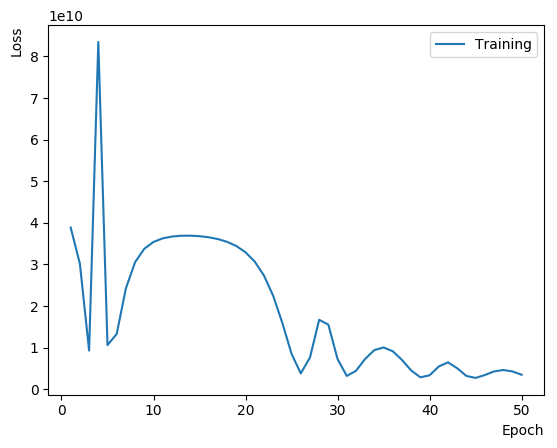

In [36]:
# Plot the loss for training set
fig,ax = plt.subplots()

x = range(1,len(losses)+1)
plt.plot(x,losses, label='Training')

plt.xlabel('Epoch',ha='right',va='top',   position=(1,0))
plt.ylabel('Loss', ha='right',va='bottom',position=(0,1))

plt.legend(loc=0,numpoints=1)

Now make the prediction on the testing set that is orthogonal to the training set.

In [0]:
tX_test = Variable(torch.from_numpy(X_test).float(),requires_grad=False) # tell pytorch we don't need to keep a history of this value (for gradients)
predictions = net(tX_test).flatten().detach().numpy()
values      = np.divide((predictions - Y_test),Y_test)        # offsets to compare predicted and actual value

Distribution = 0.038 $\pm$ 0.2878


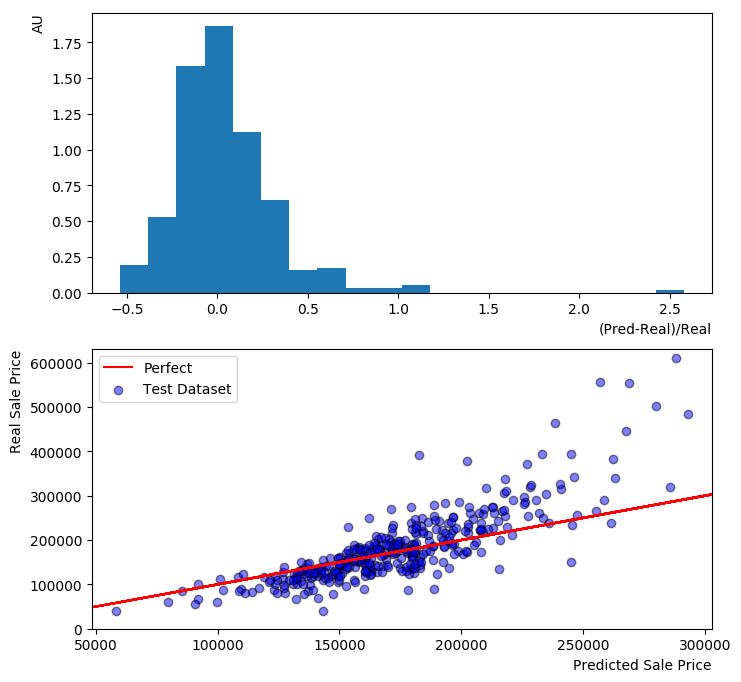

In [38]:
# Prediction
fig,ax = plt.subplots(2,1,figsize=(8,8))

plt.subplot(2,1,1)
plt.hist(values,bins=20,normed=True)
plt.xlabel("(Pred-Real)/Real",position=(1,0),ha='right')
plt.ylabel("AU",position=(0,1),ha='right')

plt.subplot(2,1,2)
plt.scatter(predictions,Y_test,color='b',edgecolor='k',alpha=0.5,label="Test Dataset");
plt.plot(Y_test,Y_test,color='r',label="Perfect")
plt.xlim(min(predictions)-10000,max(predictions)+10000)
plt.ylim(0,max(Y_test)+20000)
plt.xlabel("Predicted Sale Price",position=(1,0),ha='right')
plt.ylabel("Real Sale Price",position=(0,1),ha='right')
plt.legend()

print(r"Distribution = {0:.3f} $\pm$ {1:.4f}".format(np.mean(values),np.std(values)))

We can also quantify the output using the function `explained_variance_score` from `scikit-learn`!

In [39]:
explained_variance_score(Y_test,predictions)

0.5472289818423106

And with a first attempt with mostly random guesses for an architecture, we have something that does ~okay.  We can certainly do better!

#### Scaling the Inputs

So, as you can see, the predictions are not that great.  
Let's try again with scaled inputs.  I'll also modify the parameters inline to test different architectures.

In [48]:
# Develop the scaling on the training dataset, and then apply the same shift to the test
# scale features
scaler = MinMaxScaler()
scaler.fit(X_train)

# scale target values
scaler_target = MinMaxScaler()
scaler_target.fit(Y_train.reshape(-1,1))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


MinMaxScaler(copy=True, feature_range=(0, 1))

In [0]:
# Scale values
X_test_scale  = scaler.transform(X_test)
Y_test_scale  = scaler_target.transform([Y_test])
X_train_scale = scaler.transform(X_train)
Y_train_scale = scaler_target.transform([Y_train])

In [50]:
# Hyperparameters
# - hard-code the number of hidden layers & activation functions in the class above
n_feats = len(features)
n_nodes  = 2*n_feats    # considering rectangular models at the moment
n_epochs = 50

# Define the model
net = Net(n_feature=n_feats, nodes=n_nodes, n_output=1)     # define the network
print(net)  # net architecture

optimizer = torch.optim.Adam(net.parameters(), lr=0.2)
loss_func = torch.nn.MSELoss()  # this is for regression mean squared loss

Net(
  (hidden): Linear(in_features=20, out_features=40, bias=True)
  (predict): Linear(in_features=40, out_features=1, bias=True)
)


In [0]:
# Fit to the training dataset
losses   = []
tX_train = torch.from_numpy(X_train_scale).float()   # convert numpy arrays to tensors
tY_train = torch.from_numpy(Y_train_scale).float().flatten()

for t in range(n_epochs):
    prediction = net(tX_train).flatten()       # make prediction

    loss = loss_func(prediction, tY_train)     # compute the loss between prediction and target

    optimizer.zero_grad()                      # clear gradients for next train
    loss.backward()                            # backpropagation, compute gradients
    optimizer.step()                           # apply gradients

    losses.append(loss.data.numpy())           # keep track of loss for each epoch

Again, let's plot the loss vs epochs for the training set.

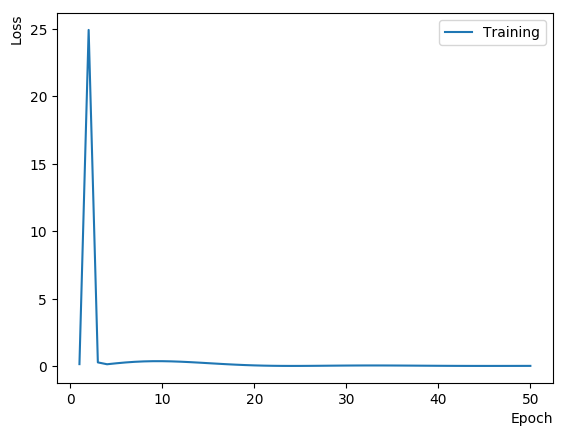

In [52]:
fig,ax = plt.subplots()

x = range(1,len(losses)+1)
plt.plot(x,losses,    label='Training')

plt.xlabel('Epoch',ha='right',va='top',   position=(1,0))
plt.ylabel('Loss', ha='right',va='bottom',position=(0,1))

plt.legend(loc=0,numpoints=1)

In [0]:
Y_test_scale = Y_test_scale.flatten()
tX_test = Variable(torch.from_numpy(X_test_scale).float(),requires_grad=False) # tell pytorch we don't need to keep a history of this value (for gradients)
predictions = net(tX_test).flatten().detach().numpy()
values      = np.divide((predictions - Y_test_scale),Y_test_scale)        # offsets to compare predicted and actual value

Distribution = -0.006 $\pm$ 1.6091
EVScore      = 0.000


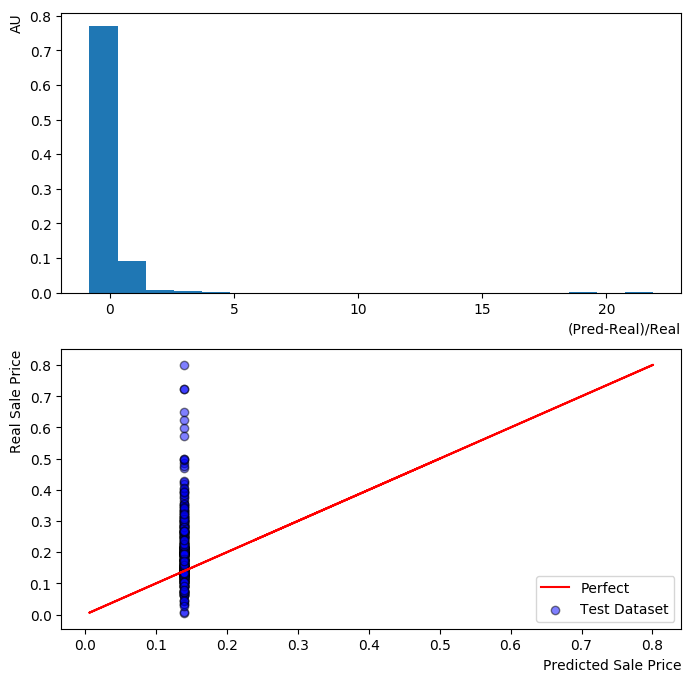

In [54]:
# Prediction
fig,ax = plt.subplots(2,1,figsize=(8,8))

plt.subplot(2,1,1)
plt.hist(values,bins=20,normed=True)
plt.xlabel("(Pred-Real)/Real",position=(1,0),ha='right')
plt.ylabel("AU",position=(0,1),ha='right')

plt.subplot(2,1,2)
plt.scatter(predictions,Y_test_scale,color='b',edgecolor='k',alpha=0.5,label="Test Dataset");
plt.plot(Y_test_scale,Y_test_scale,color='r',label="Perfect")
plt.xlabel("Predicted Sale Price",position=(1,0),ha='right')
plt.ylabel("Real Sale Price",position=(0,1),ha='right')
plt.legend()

print(r"Distribution = {0:.3f} $\pm$ {1:.4f}".format(np.mean(values),np.std(values)))
print(r"EVScore      = {0:.3f}".format(explained_variance_score(Y_test_scale,predictions)))

In [0]:
# Let's transform the target values back to the nominal scale and remake the plots
predictions = scaler_target.inverse_transform(model.predict(X_test_scale))  # convert the data back to the original scale
values      = np.divide((predictions.flatten() - Y_test),Y_test)        # offsets to compare predicted and actual value

# Prediction
fig,ax = plt.subplots(2,1,figsize=(8,8))

plt.subplot(2,1,1)
plt.hist(values,bins=20,normed=True)
plt.xlabel("(Pred-Real)/Real",position=(1,0),ha='right')
plt.ylabel("AU",position=(0,1),ha='right')

plt.subplot(2,1,2)
plt.scatter(predictions,Y_test,color='b',edgecolor='k',alpha=0.5,label="Test Dataset");
plt.plot(Y_test,Y_test,color='r',label="Perfect")
# plt.xlim(min(predictions)-10000,max(predictions)+10000)
# plt.ylim(0,max(Y_test)+20000)
plt.xlabel("Predicted Sale Price",position=(1,0),ha='right')
plt.ylabel("Real Sale Price",position=(0,1),ha='right')
plt.legend()

evs = explained_variance_score(Y_test,predictions)

print(r"Distribution = {0:.3f} $\pm$ {1:.4f} :: {2:.3f}".format(np.mean(values),np.std(values),evs))

After scaling the inputs, the performance is noticeably better -- which seems reasonable because now the weights are being updated by values on the same scale, and individual parameters aren't dominating the training.

#### Conclusions

Of course, there are _many_ hyperparameters that we can adjust to optimize performance and prevent overtraining.
With time, I'll revisit this to have a better idea as to what each parameter can affect.

After testing the different methods, it's easy to see how neural networks are more popular -- the great performance and easy-to-use API from `keras` creates a very low barrier to entry!

The next notebooks will tackle different datasets from Kaggle -- feel free to also check out the `Julia` notebooks (where I'm trying to learn the Julia language for data science).